# First question : Who are people talking about cinema, regarding gender and age ?

In [ ]:
import pandas as pd
import bz2
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from pathlib import Path
from datetime import datetime, date
from dateutil import relativedelta

from ressources import config

In [ ]:
#function to format datetime with all exceptions 
def parse_date(date):
    try:
        if not isinstance(date, str):
            return np.NaN
        elif len(date)%10 != 0:
            return np.NaN
        elif date == 'None' or date[0] == '-':
            return np.NaN
        elif '00.00.0000' in date[0:10] :
            return '01.01.0001'
        elif '00.0000' in date[0:10] :
            return datetime.strptime(date[0:10], '%d.00.0000').strftime('%d.%m.%Y')
        elif '0000' in date[0:10] :
            return datetime.strptime(date[0:10], '%d.%m.0000').strftime('%d.%m.%Y')
        elif '+1939-02-29T00:00:00Z' in date:
            return '28.02.1939'
        elif '0' in date[6]: 
            return np.NaN
        elif '00' in date[6:7]: 
            return np.NaN
        else :
            return datetime.strptime(date[0:10], '%d.%m.%Y').strftime('%d.%m.%Y')
    except ValueError as e:
        if str(e) == 'day is out of range for month':
            return datetime.strptime(date[0:8], '%Y.%m').strftime('%d.%m.%Y')
        else:
            print(date)
            raise e

## Task 1

We first import the data. A dataframe with url containing the key words 'movies', 'films' and 'cinema' were extracted from Quotebank in a json file.

Summary of the features:

- quoteID : primary key of the quotation
- quotation : text of the longest encountered original form of the quotation
- speaker : selected most likely speaker. This matches the the first speaker entry in `probas`
- qids : wikidata IDs of all aliases that match the selected speaker
- date : earliest occurrence date of any version of the quotation
- numOccurences : number of time this quotation occurs in the articles
- probas : array representing the probabilities of each speaker having uttered the quotation.
- urls : list of links to the original articles containing the quotation 
- phase : corresponding phase of the data in which the quotation first occurred (A-E)

Unattributed quotes has already been filtered. Indeed, it is not relevant to take the second most likely person, since it make no sense to take a a more likely speaker than no one.

In [ ]:
# Loading the dataframe to have a look on the data
path_to_file = '../generated/QUOTEBANK/movie_quotes-2018.json.bz2'

df_movie_quote = pd.read_json(path_to_file, lines=True, compression='bz2')
df_movie_quote.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,dob
0,2018-12-06-000021,... a race to see who could sail around the wo...,James Marsh,"[Q2720543, Q41757028, Q56510432, Q6138937, Q99...",2018-12-06 12:00:34,1,"[[James Marsh, 0.6787], [None, 0.3213]]",[http://filmthreat.com/reviews/the-mercy/],E,male,30.04.1963
1,2018-05-06-000178,... never as fascinating as the philosophy or ...,Ed Moy,[Q26828697],2018-05-06 01:00:55,1,"[[Ed Moy, 0.7867], [None, 0.2133]]",[http://filmthreat.com/reviews/luminaries/],E,male,None
2,2018-07-09-000437,"$100,000 to punch me in the face right now.",Johnny Depp,[Q37175],2018-07-09 21:26:13,4,"[[Johnny Depp, 0.5001], [None, 0.4624], [Brad ...",[https://www.vanityfair.com/hollywood/2018/07/...,E,male,09.06.1963
3,2018-03-16-002261,A lot of it is pure entertainment but the film...,Tim White,"[Q15443196, Q16762431, Q18164313, Q18600422, Q...",2018-03-16 09:30:00,1,"[[Tim White, 0.912], [None, 0.088]]",[http://www.capitalgazette.com/entertainment/a...,E,male,None
4,2018-05-20-000976,A moment during the making of Raazi. Words can...,Alia Bhatt,[Q4725343],2018-05-20 11:01:19,2,"[[Alia Bhatt, 0.8059], [None, 0.1805], [Ashwin...",[https://www.thestatesman.com/entertainment/bo...,E,female,15.03.1993


In [ ]:
#drop columns that aren't relevant for the question
df_movie_quote.drop(['qids', 'probas', 'urls', 'phase', 'quoteID'], axis = 1, inplace = True)

In [ ]:
df_movie_quote.head()

,quotation,speaker,date,numOccurrences,gender,dob
0,... a race to see who could sail around the wo...,James Marsh,2018-12-06 12:00:34,1,male,30.04.1963
1,... never as fascinating as the philosophy or ...,Ed Moy,2018-05-06 01:00:55,1,male,None
2,"$100,000 to punch me in the face right now.",Johnny Depp,2018-07-09 21:26:13,4,male,09.06.1963
3,A lot of it is pure entertainment but the film...,Tim White,2018-03-16 09:30:00,1,male,None
4,A moment during the making of Raazi. Words can...,Alia Bhatt,2018-05-20 11:01:19,2,female,15.03.1993


## Task 2 - Describing data

In [117]:
print(f'There are {len(df_movie_quote)} quotes about cinema')

There are 427368 quotes about cinema


## Task 3 - Analysing data

- Group by gender
- Create visualisations

In [142]:
df_movie_quote.groupby(['speaker']).count().sort_values(by = 'quotation', ascending=False)

,quotation,date,numOccurrences,gender,dob
speaker,,,,,
Kevin Feige,1769,1769,1769,1769,1769
Joe Russo,1362,1362,1362,1362,1362
Karan Johar,1102,1102,1102,1102,1102
Steven Spielberg,1080,1080,1080,1080,1080
Salman Khan,992,992,992,992,992
...,...,...,...,...,...
John Magri,1,1,1,1,1
John Mackin,1,1,1,1,1
John MacDonald,1,1,1,1,1


With the groupby, we see that the person who talks the most about cinema is Kevin Feige, who is an american film producer, what is relevant for our study.

### Comparing representation of women's speech in all quotation from 2018 with cinema quotation from 2018

In [129]:
#dictionnary with gender of all speaker from 2018
with open('../generated/QUOTEBANK/dict_gender_all.pickle', 'rb') as f: 
    dict_gender_quote = pickle.loads(f.read())
dict_gender_quote

{'male': 14252335, 'female': 3090108, 'other': 221386}

In [130]:
df_gender = pd.DataFrame.from_dict(dict_gender_quote, orient ='index', columns = ['Sum'])
df_gender

,Sum
male,14252335
female,3090108
other,221386


In [131]:
#calculate a percentage
for i in df_gender['Sum']:
    i = i / df_gender['Sum'].sum()
    print(i)

0.8114594488479705
0.17593589643807167
0.012604654713957874


In [132]:
dict_gender = {'male': 0.8114594488479705, 'female': 0.17593589643807167, 'other': 0.012604654713957874}

df_gender_perc = pd.DataFrame.from_dict(dict_gender, orient ='index', columns = ['Sum'])
df_gender_perc

,Sum
male,0.811459
female,0.175936
other,0.012605


In [107]:
df_gender.sum()

Sum    17563829
dtype: int64

In [108]:
gender_cinema = list(df_movie_quote['gender'].value_counts(normalize=True).mul(100))

In [109]:
df_gender_perc.rename(columns={'Sum' : 'All quotes (N = 17563829)'}, inplace = True)

In [110]:
df_gender_perc['All quotes (N = 17563829)'] = df_gender_perc['All quotes (N = 17563829)'].mul(100)

In [111]:
df_gender_perc['Cinema'] = gender_cinema

In [112]:
df_gender_perc.rename(columns={'Cinema' : 'Cinema\'s quotes (N = 427368)'}, inplace = True)

In [113]:
df_gender_perc

,All quotes (N = 17563829),Cinema's quotes (N = 427368)
male,81.145945,69.438517
female,17.593590,29.459155
other,1.260465,1.102329


Text(0.5, 0, '\nPercentage of speakers')

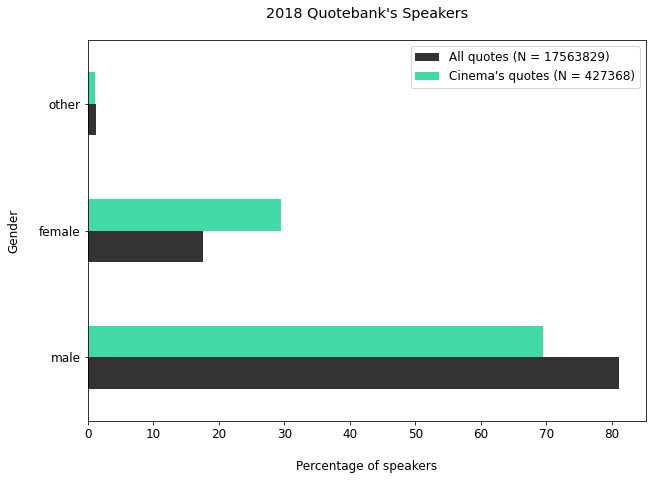

In [126]:
plt.rc('font', size=12) 

df_gender_perc.plot.barh(figsize=(10, 7),
                        color={"All quotes (N = 17563829)": "#333", "Cinema\'s quotes (N = 427368)": "#41D9A4"})

plt.title("2018 Quotebank's Speakers\n")
plt.ylabel("Gender\n")
plt.xlabel("\nPercentage of speakers")
#plt.savefig('../results/Plot_speaker_by_gender_all.png', bbox_inches='tight')